In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear, Softmax, Sigmoid, Module
from scipy.optimize import minimize
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.connectors import TorchConnector
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.8.0


In [2]:
# Creating Circuit

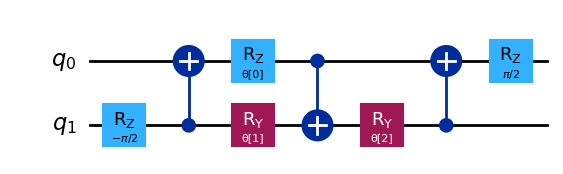

In [3]:
# Two qubit unitary as defined
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Visual
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

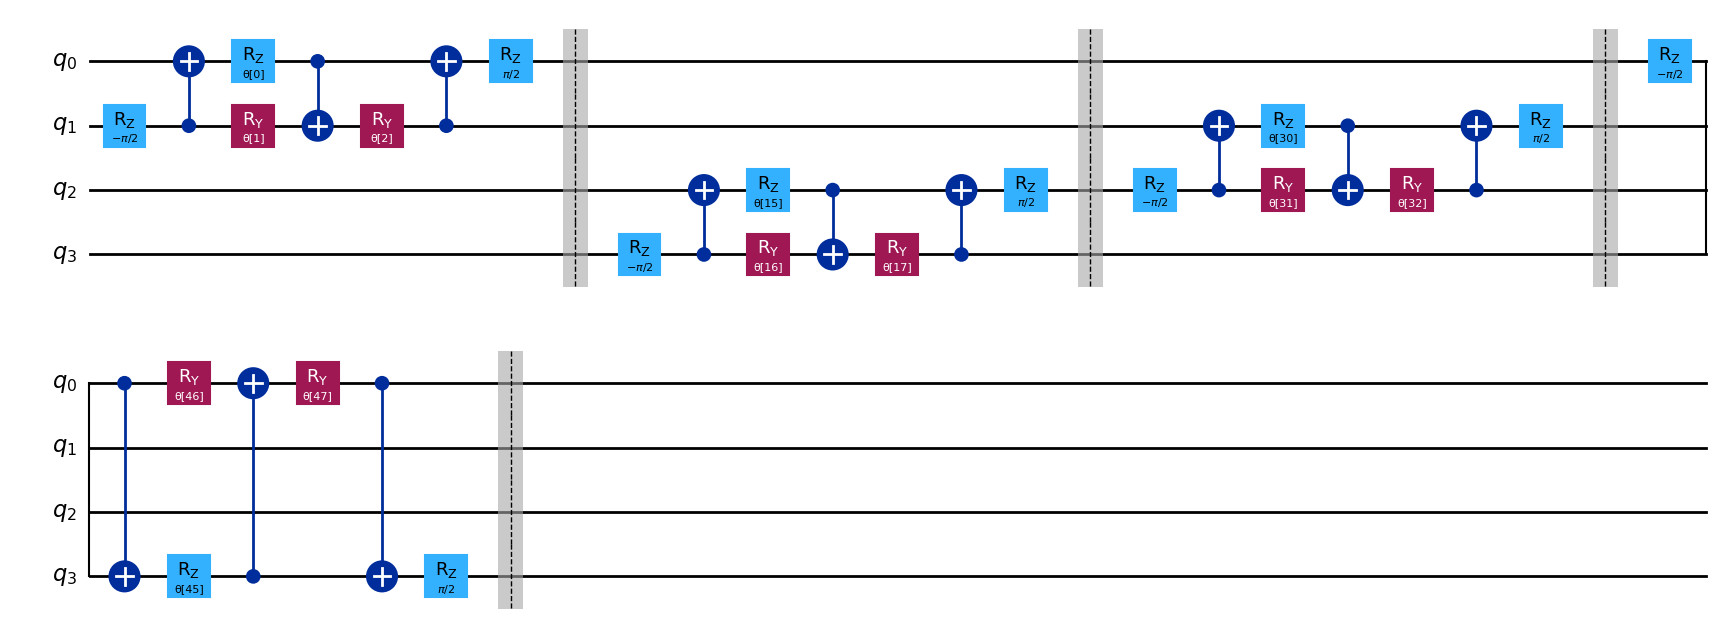

In [4]:
# Create Layer (Repeating Circuit on Neighboring Qubits).
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

# Visual
circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

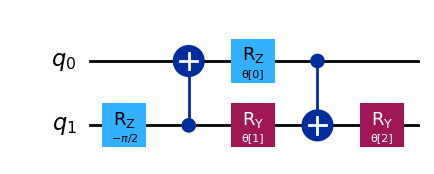

In [5]:
# Defining Pool Circuit
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

# Visual
params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

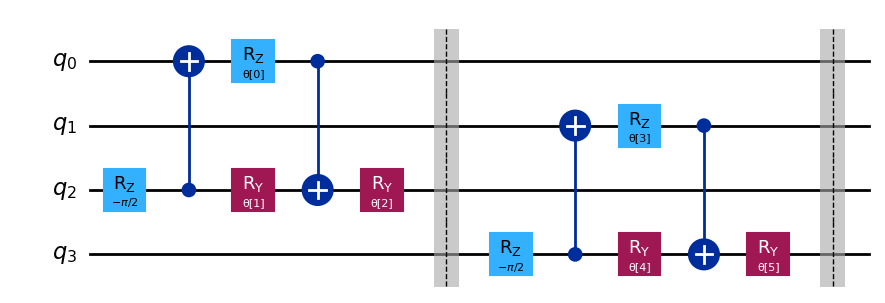

In [6]:
# Defining Pool Layer (Repeating Circuit on Neighboring Qubits)
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

# Visual
sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

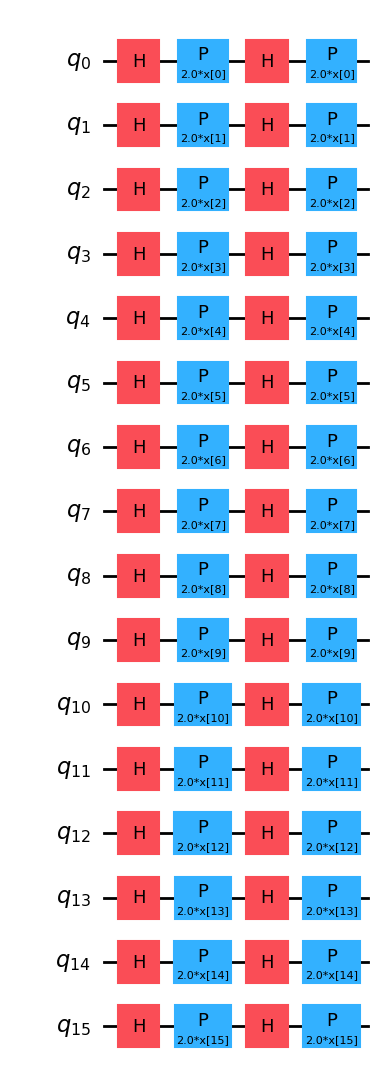

In [7]:
# Feature Map Instantiation
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

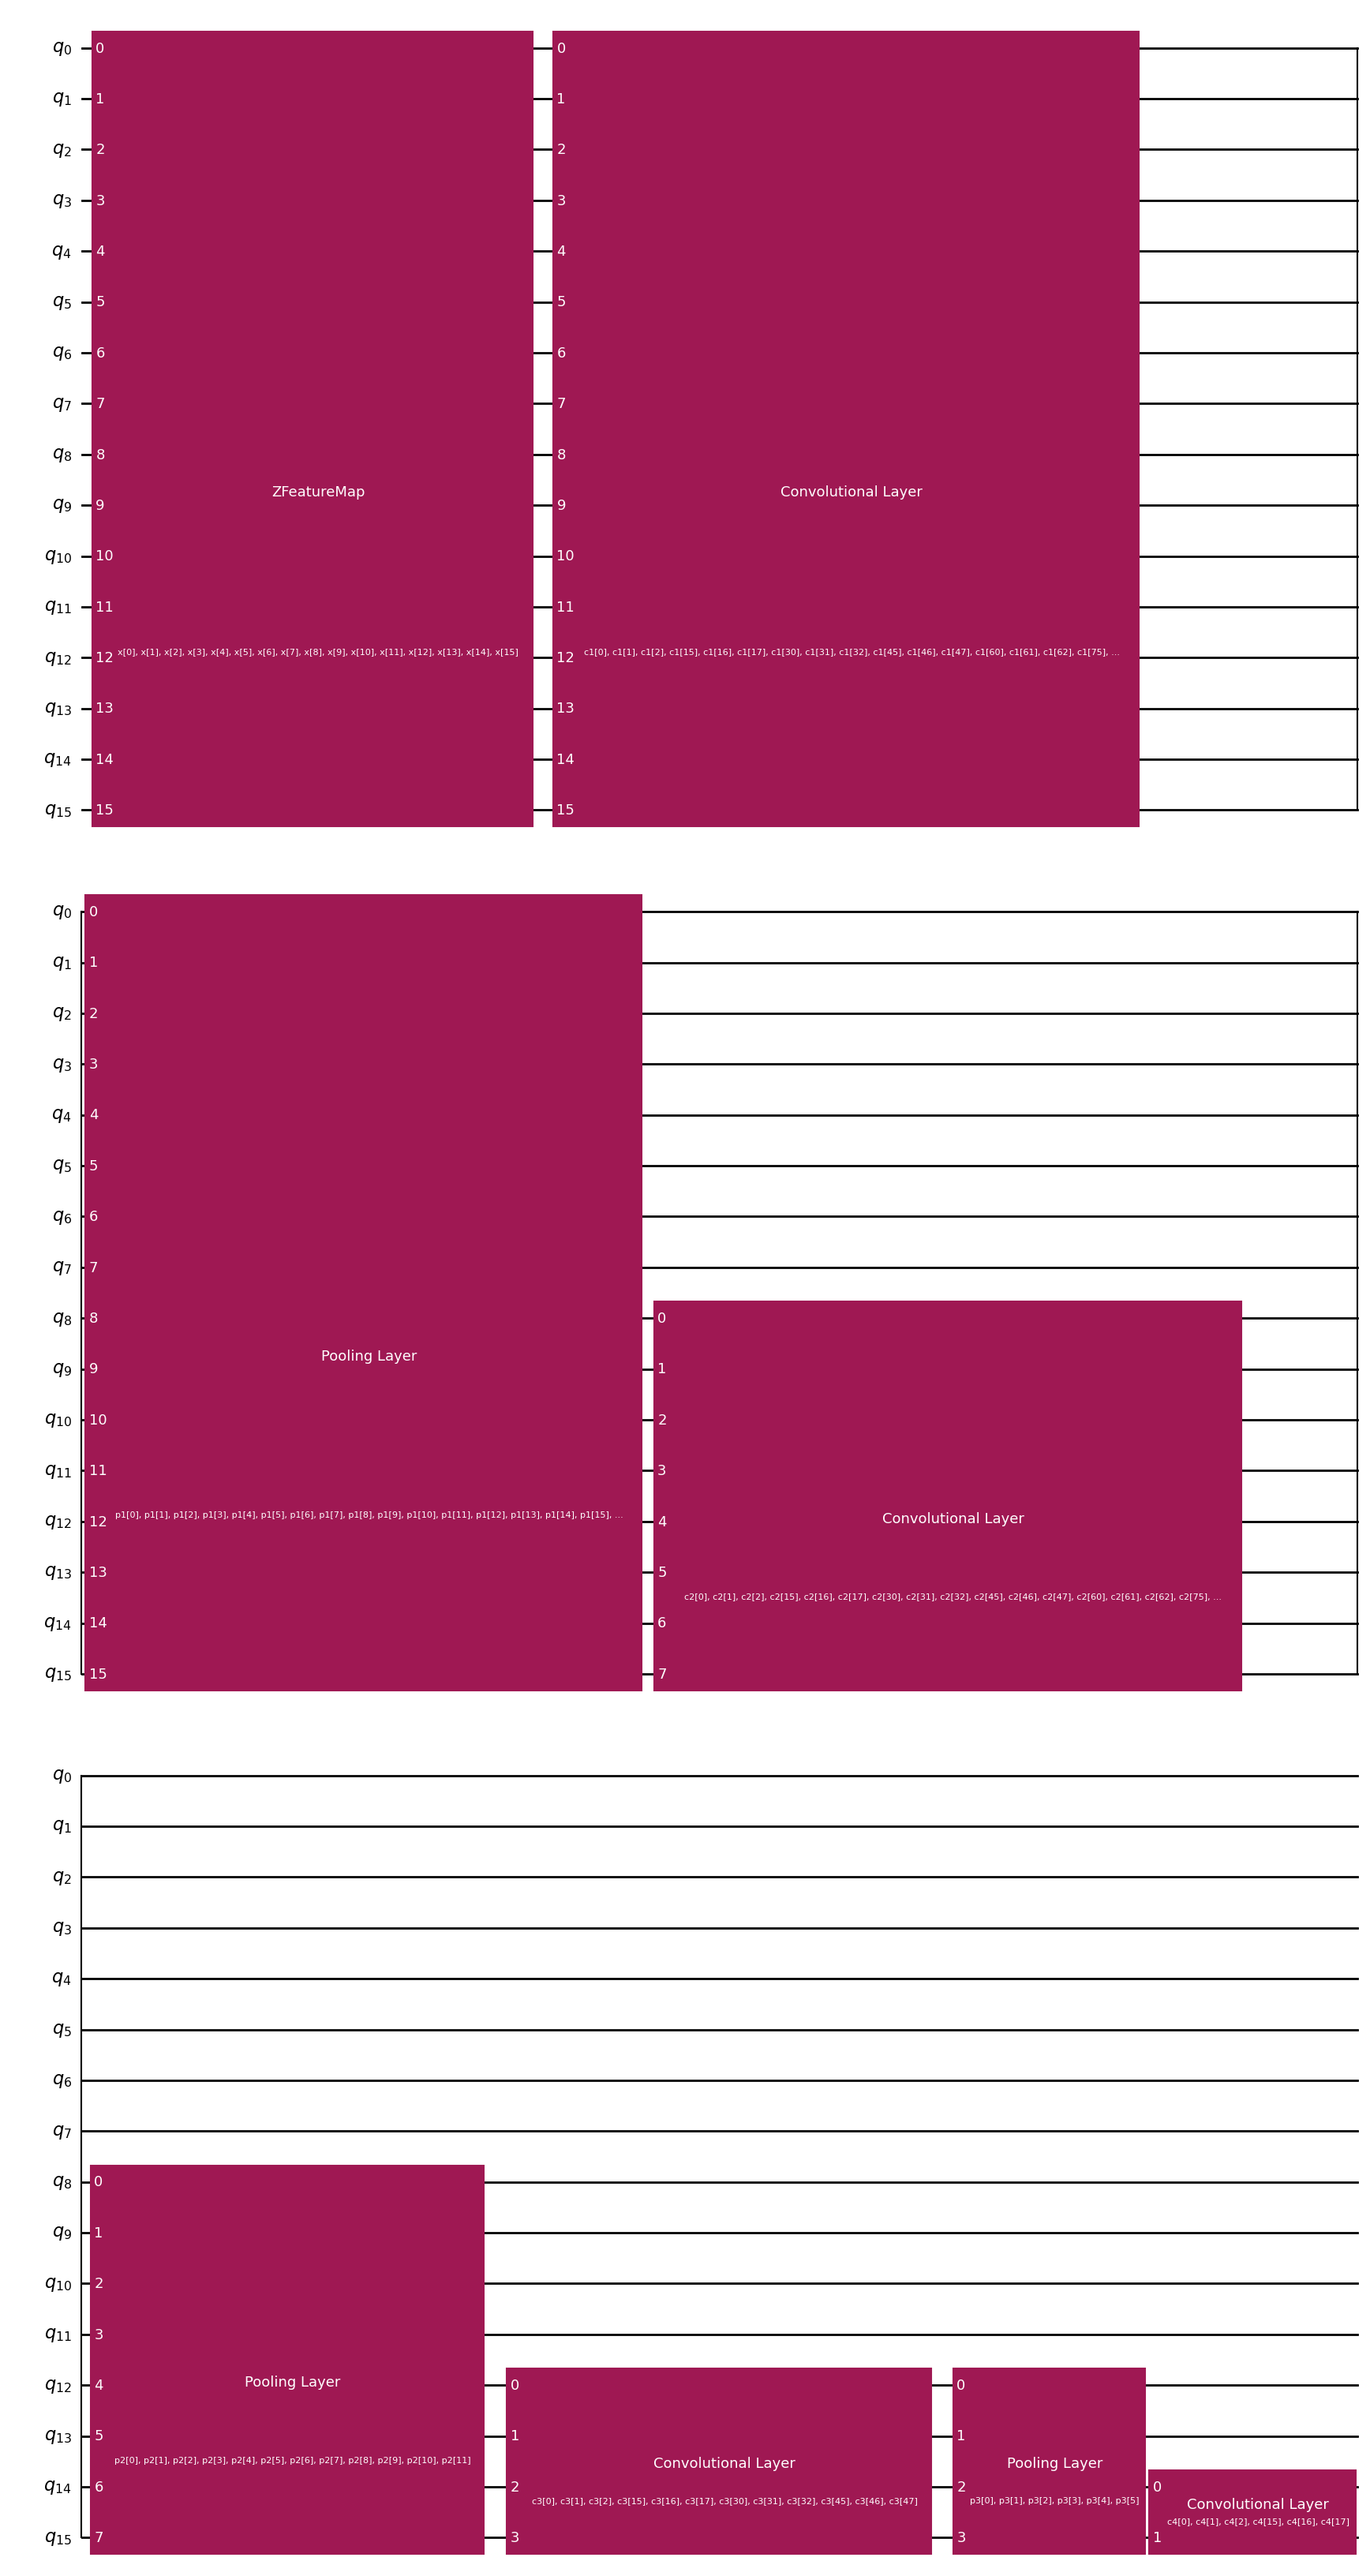

In [8]:
# Ansatz Instantiation Method
from qiskit import ClassicalRegister, QuantumRegister
def create_QCNN():
    q_reg = QuantumRegister(16, "q_reg")
    ansatz = QuantumCircuit(q_reg, name="Ansatz")

    # First Convolutional Layer
    ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

    # First Pooling Layer
    ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

    # Second Convolutional Layer
    ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

    # Second Pooling Layer
    ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

    # Third Convolutional Layer
    ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

    # Third Pooling Layer
    ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

    # Fourth Convolutional Layer
    ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

    # Combining the feature map and ansatz
    circuit = QNNCircuit(16)
    circuit.feature_map = feature_map
    circuit.ansatz = ansatz
    return circuit

# Visual
display(create_QCNN().draw("mpl"))

In [9]:
# Creating/Formatting Data

In [10]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

2024-12-07 16:09:36.410825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733616576.422984    8237 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733616576.426854    8237 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 16:09:36.439207: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of original training examples: 60000
Number of original test examples: 10000


In [11]:
# Filter Values
a = 3
b = 4
def filter_abcd(x, y):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    return x,y

In [12]:
# Filtering using previous method.
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11973
Number of filtered test examples: 1992


4


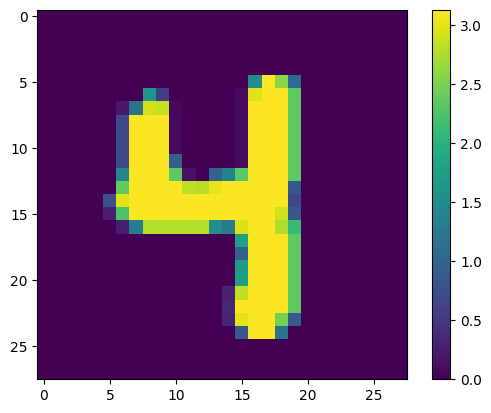

In [13]:
# Displaying Sample Image
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

In [14]:
# Resizing (Quantum Computing Simulation Limit)
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

I0000 00:00:1733616578.475469    8237 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


4


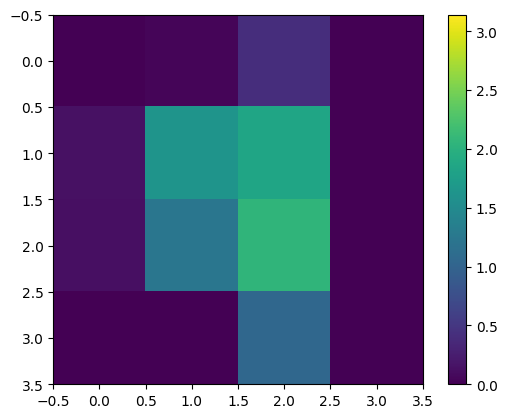

In [15]:
# Displaying Image Sample After Resizing
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [16]:
# Formatting Helper Methods
def format_data(a,b):
    x_reshaped = []
    x1_reshaped = []

    for g in a:
        x_reshaped.append(g.reshape(1,16))

    for g in b:
        x1_reshaped.append(g.reshape(1,16))

    final_x = []
    final_x1 = []

    for entry in x_reshaped:
        final_x.append(entry[0])

    for entry in x1_reshaped:
        final_x1.append(entry[0])
    return final_x, final_x1

def format_labels(y):
    y_temp = []
    for entry in y:
        if entry == a:
            y_temp.append(0)
        elif entry == b:
            y_temp.append(1)
    return y_temp

In [17]:
x,x1 = format_data(x_train_small, x_test_small)

# Easier to work with names
y = y_train
y1 = y_test

# Setting labels to 0,1,2,3 for easy reference later
y = format_labels(y)
y1 = format_labels(y1)

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)

# Limiting training dataset to lower training time.
x = x[0:256]
y = y[0:256]
x1 = x1[0:256]
y1 = y1[0:256]
print(x)
print(y)

[[0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 [0.         0.         0.0341942  ... 0.43195325 0.         0.        ]
 ...
 [0.         0.         0.2499194  ... 0.0206171  0.18681097 0.        ]
 [0.         0.09629691 0.17650244 ... 0.32082212 1.137963   0.        ]
 [0.         0.36431915 0.16393104 ... 0.01055997 0.8194038  0.        ]]
[1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1
 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0
 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0
 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1
 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1
 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1
 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1]


In [18]:
# Additional Helper Functions
def count(y):
    counta = 0
    countb = 0
    for i in range(len(y)):
        if y[i] == 0:
            counta+=1
        elif y[i] == 1:
            countb+=1
    return(counta, countb)

def balance_lists(x, y, max_count):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1
    return x_balanced, y_balanced

def shuffle(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

In [19]:
# Further Data Cleaning Using Helper Functions
nums = count(y)
print("original:", nums)
max_count = min(nums)
print("max_count =", max_count)
x,y = balance_lists(x, y, max_count)

print("balanced:", count(y))

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

x,y = shuffle(x,y)
print("shuffled:", count(y))

print("final:", x)
print(y)

original: (118, 138)
max_count = 118
balanced: (118, 118)
shuffled: (118, 118)
final: [[0.         0.366582   0.03394278 ... 0.34470776 0.43044475 0.        ]
 [0.         0.24287944 0.02614851 ... 0.02564565 0.36281055 0.        ]
 [0.         0.05883415 1.0632889  ... 1.1691401  0.32987353 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.12747398 0.        ]
 [0.         0.02438851 0.21999946 ... 1.1781915  0.43698183 0.        ]
 [0.         0.21999948 1.2091172  ... 0.9302835  0.07215983 0.        ]]
[0 1 0 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0
 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1
 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 1
 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 1 0 1 1 1
 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0
 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0
 0 1 1 1 1 1 1 0 1 1

In [20]:
# Tensor for Pytorch
X = torch.tensor(x, dtype=torch.float32).to("cuda")
Y = torch.tensor(y, dtype=torch.long).to("cuda")
X1 = torch.tensor(x1, dtype=torch.float32).to("cuda")
Y1 = torch.tensor(y1, dtype=torch.long).to("cuda")

In [21]:
# One-Hot Encoding for Final Processing
num_classes = 2
Y = (torch.nn.functional.one_hot(Y, num_classes=num_classes).float())
Y1 = (torch.nn.functional.one_hot(Y1, num_classes=num_classes).float())

In [22]:
print(X,Y,X1,Y1)

tensor([[0.0000, 0.3666, 0.0339,  ..., 0.3447, 0.4304, 0.0000],
        [0.0000, 0.2429, 0.0261,  ..., 0.0256, 0.3628, 0.0000],
        [0.0000, 0.0588, 1.0633,  ..., 1.1691, 0.3299, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1275, 0.0000],
        [0.0000, 0.0244, 0.2200,  ..., 1.1782, 0.4370, 0.0000],
        [0.0000, 0.2200, 1.2091,  ..., 0.9303, 0.0722, 0.0000]],
       device='cuda:0') tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
  

In [23]:
# Training

In [24]:
# Pytorch Circuit Module
import torch.nn as nn
class Model(Module): # Simplified
    def __init__(self, qnn_module):
        super().__init__()
        self.qnn_module = qnn_module
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, x):
        x = self.qnn_module(x)
        x = self.softmax(x)
        return x

In [25]:
from qiskit_aer.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.utils import algorithm_globals

# Reproducable seeds
num_qubits = 16
algorithm_globals.random_seed = 65
seed = 90

# Creating GPU compatible Estimator primitive
sampler = Estimator()
sampler.set_options(device='GPU')
sampler.set_options(method="statevector")
sampler.set_options(seed = seed)

# Setting observables on 15th and 16th qubits.
observable_z15 = SparsePauliOp.from_sparse_list([("Z", [14], 1)], num_qubits=num_qubits)
observable_z16 = SparsePauliOp.from_sparse_list([("Z", [15], 1)], num_qubits=num_qubits)
observables = [observable_z15, observable_z16]

# Instantiating underlying EstimatorQNN
estimator = EstimatorQNN(
    estimator = sampler,
    circuit = create_QCNN(),
    observables = observables,
)

# Initial Forward Weights
weights = algorithm_globals.random.random(estimator.num_weights)

# Checking Data Forward Result
estimator.forward(input_data = x1[:30], weights = weights)

/tmp/ipykernel_8237/169549018.py:22: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator = EstimatorQNN(
/tmp/ipykernel_8237/169549018.py:22: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (16). If `circuit` is transpiled, this may cause unstable behaviour.
  estimator = EstimatorQNN(


array([[ 0.07226562, -0.07421875],
       [ 0.08789062, -0.00195312],
       [ 0.125     ,  0.        ],
       [ 0.12109375, -0.03710938],
       [ 0.13867188, -0.05664062],
       [ 0.14453125, -0.01757812],
       [ 0.09179688, -0.09179688],
       [ 0.0546875 , -0.07421875],
       [ 0.1484375 , -0.015625  ],
       [ 0.07421875, -0.09179688],
       [ 0.109375  , -0.08984375],
       [-0.03320312,  0.03710938],
       [ 0.11523438, -0.0625    ],
       [ 0.046875  , -0.00585938],
       [ 0.04101562, -0.02148438],
       [ 0.11328125, -0.06054688],
       [ 0.12890625,  0.015625  ],
       [ 0.11328125, -0.00585938],
       [-0.00976562, -0.0859375 ],
       [ 0.16210938, -0.04492188],
       [ 0.05273438,  0.00195312],
       [ 0.0078125 , -0.01367188],
       [ 0.04492188, -0.08984375],
       [-0.01171875, -0.10742188],
       [-0.03515625, -0.04296875],
       [ 0.06054688, -0.05664062],
       [ 0.09375   , -0.05078125],
       [ 0.1015625 , -0.12304688],
       [ 0.12890625,

In [26]:
# Wrapping estimator with initial weights under TorchConnecter, itself under Pytorch Module.
model = Model(TorchConnector(estimator, weights))
model.to("cuda")
next(model.parameters()).is_cuda

True

In [27]:
model(X[:30])

tensor([[0.5419, 0.4581],
        [0.5220, 0.4780],
        [0.5268, 0.4732],
        [0.5380, 0.4620],
        [0.5463, 0.4537],
        [0.5448, 0.4552],
        [0.5501, 0.4499],
        [0.5414, 0.4586],
        [0.5288, 0.4712],
        [0.5224, 0.4776],
        [0.5400, 0.4600],
        [0.5171, 0.4829],
        [0.5521, 0.4479],
        [0.5059, 0.4941],
        [0.5400, 0.4600],
        [0.5443, 0.4557],
        [0.5039, 0.4961],
        [0.5302, 0.4698],
        [0.5132, 0.4868],
        [0.5487, 0.4513],
        [0.5220, 0.4780],
        [0.5098, 0.4902],
        [0.5234, 0.4766],
        [0.5312, 0.4688],
        [0.5254, 0.4746],
        [0.5366, 0.4634],
        [0.5263, 0.4737],
        [0.5492, 0.4508],
        [0.5477, 0.4523],
        [0.5132, 0.4868]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [28]:
# Callback Helper Functions
loss_func = tf.keras.losses.CategoricalCrossentropy()

def accuracy(output, Y):
    acc = 0
    for i in range(Y.size(dim=0)):
        val = output[i]
        if (torch.argmax(val) == torch.argmax(Y[i])):
            acc+=1
    return ((acc/(Y.size(dim=0)))*100)

def objective_function(weights):
    global X
    global Y
    if(i != 1 and i%333 == 0):
        indices = torch.randperm(X.size()[0])
        X=X[indices]
        Y=Y[indices]
        print(X,Y)
    # Referencing Global Variables
    global data
    # Local Variable
    total_loss = 0.0
    # Overiding with new data
    model = Model(TorchConnector(estimator, weights)).to("cuda")
    # Getting Output
    output = model(X)
    loss_output = output.detach().cpu().numpy()
    loss_Y = Y.detach().cpu().numpy()
    # Calculate Loss
    loss = loss_func(loss_output, loss_Y).numpy()
    # Append Checkpoint Data Points to Tracker
    val = f"Iteration: {i}; Accuracy: {accuracy(output, Y)}%; Loss: {loss}"
    data.append(val)
    total_loss += loss
    loss_list.append(total_loss)
    return total_loss

def callback(weights):
    # Iteration Tracking
    global i
    global weight_list
    # Printing Checkpoint Data Points in Tracker
    print("\n".join(data))
    # Plotting Loss Function
    plt.title("Loss value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss function value")
    plt.plot(range(len(loss_list)), loss_list)
    plt.show()
    # Printing Weights
    weight_list.append(weights)
    print(weights)
    # Iteration Counter
    i+=1
    # Clearing Previous Graph/Weights
    clear_output(wait=True)

In [ ]:
# Training Function
def fit(weights=None, losslist=None, iter= 1000, fresh_start = False):
    global i
    global data
    global weight_list
    global loss_list
    if(fresh_start):
        loss_list = []
        data = []
        weight_list = []
        weights = algorithm_globals.random.random(estimator.num_weights)
        i = 1
    else:
        if 'data' not in globals(): data = []
        else: data = data
        if 'weight_list' not in globals():weight_list = []
        else: weight_list = weight_list
        if 'i' not in globals() and 'i' not in locals(): i = 1
        else: i = i
        if losslist is not None: losslist = losslist
        elif (('loss_list' not in globals() and 'loss_list' not in locals()) and losslist == None): loss_list = []
        elif 'loss_list' not in globals() and 'loss_list' not in locals(): loss_list = losslist
        else: loss_list = loss_list
        if weights is not None: weights = weights
        elif (len(weight_list)>0):
            weights = weight_list[-1]
        elif (('result' not in locals() and 'result' not in globals())) and weights == None:
            weights = algorithm_globals.random.random(estimator.num_weights)
        else:
            weights = result[0].x
            loss_list = result[2]
    
    result = minimize(
        fun=objective_function,
        callback = callback,
        x0=weights,
        method='COBYLA',
        options={'maxiter': iter},
    )
    return result, data, loss_list, weight_list

Iteration: 1; Accuracy: 43.64406779661017%; Loss: 8.120026588439941
Iteration: 2; Accuracy: 38.983050847457626%; Loss: 8.129115104675293
Iteration: 3; Accuracy: 40.25423728813559%; Loss: 8.115079879760742
Iteration: 4; Accuracy: 40.25423728813559%; Loss: 8.109184265136719
Iteration: 5; Accuracy: 41.94915254237288%; Loss: 8.111390113830566
Iteration: 6; Accuracy: 41.52542372881356%; Loss: 8.109956741333008
Iteration: 7; Accuracy: 37.71186440677966%; Loss: 8.116719245910645
Iteration: 8; Accuracy: 46.186440677966104%; Loss: 8.09083080291748
Iteration: 9; Accuracy: 45.76271186440678%; Loss: 8.067749977111816
Iteration: 10; Accuracy: 44.91525423728814%; Loss: 8.086104393005371
Iteration: 11; Accuracy: 41.52542372881356%; Loss: 8.11931037902832
Iteration: 12; Accuracy: 52.54237288135594%; Loss: 8.03260612487793
Iteration: 13; Accuracy: 52.96610169491526%; Loss: 8.012777328491211
Iteration: 14; Accuracy: 60.16949152542372%; Loss: 7.972713947296143
Iteration: 15; Accuracy: 53.813559322033896%

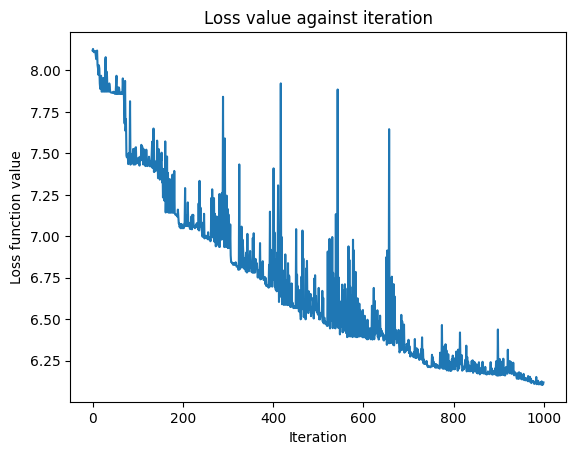

[-0.11161124  1.76187234  0.58629636  0.16629701  0.5217769   0.54256523
  1.51396359  1.02499473 -1.23553862  0.38060169  0.48711266  0.61400638
  1.46013876  1.42302127  1.39687971  0.60165304  2.59219741  0.33075971
  0.52426225  1.77794702 -0.16283729  1.5996405   0.54615781  0.6525023
  0.01085815  1.00700025  0.77852409  0.30294328  0.37930639  0.04073703
 -0.13073941  0.59329426 -0.22626366  0.15850624 -0.68308259  0.62096906
  0.26968355  1.02140154  0.61507579  1.36399072  0.68057243  0.15918394
  0.65468067  0.34703774 -0.1398792   1.17496111  1.89021377  1.34890349
  1.60729185  2.0830471   0.83447088 -0.06359212  0.47013412  0.97521477
  0.74132949  0.26539512  1.11154104  0.16433744  0.19758619  0.91783739
  0.82866736  0.03940748  1.00681496  1.35003654  1.27648598 -0.19298377
  0.01964212 -0.02425575  1.10833081  1.89301318  1.62202457 -0.3567398
  1.42815041 -0.15476277  1.68675921  1.52281126  0.94093315  0.80042713
  1.0660315   0.34954448  1.28174658  0.96639714 -0.1

In [30]:
%time
# Call Training Function and Save as Result
result = fit(iter=1000, fresh_start=False)

In [31]:
savemodel = Model(TorchConnector(estimator, result[0].x))
print(next(model.parameters()).is_cuda)
torch.save(savemodel, "TwoQubits(One_Hot)")

True


In [32]:
evalmodel = torch.load("TwoQubits(One_Hot)", weights_only=False).to("cuda")
evalmodel.eval()
output0 = evalmodel(X)
output1 = evalmodel(X1)
print(f"Train Accuracy: {accuracy(output0, Y)}%")
print(f"Test Accuracy: {accuracy(output1, Y1)}%")

Train Accuracy: 73.30508474576271%
Test Accuracy: 69.140625%


In [33]:
def translate(array):
    arr = []
    for e in array:
        arr.append(torch.argmax(e))
    return arr
print(f"output 0: {translate(output0)}, \n Y:       {translate(Y)}, \n output 1: {translate(output1)}, \n Y1:       {translate(Y1)}")

output 0: [tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1,

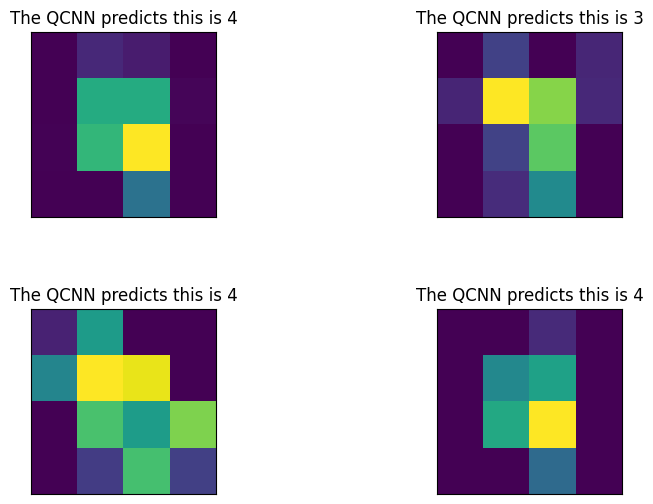

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(X1.detach().cpu().numpy()[i].reshape(4, 4), aspect="equal")
    if torch.argmax(output0[i]) == 0:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if torch.argmax(output0[i]) == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 4")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [35]:
print(result)

( message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 6.104329586029053
       x: [-1.116e-01  1.762e+00 ... -7.890e-02  1.882e-01]
    nfev: 1000
   maxcv: 0.0, ['Iteration: 1; Accuracy: 43.64406779661017%; Loss: 8.120026588439941', 'Iteration: 2; Accuracy: 38.983050847457626%; Loss: 8.129115104675293', 'Iteration: 3; Accuracy: 40.25423728813559%; Loss: 8.115079879760742', 'Iteration: 4; Accuracy: 40.25423728813559%; Loss: 8.109184265136719', 'Iteration: 5; Accuracy: 41.94915254237288%; Loss: 8.111390113830566', 'Iteration: 6; Accuracy: 41.52542372881356%; Loss: 8.109956741333008', 'Iteration: 7; Accuracy: 37.71186440677966%; Loss: 8.116719245910645', 'Iteration: 8; Accuracy: 46.186440677966104%; Loss: 8.09083080291748', 'Iteration: 9; Accuracy: 45.76271186440678%; Loss: 8.067749977111816', 'Iteration: 10; Accuracy: 44.91525423728814%; Loss: 8.086104393005371', 'Iteration: 11; Accuracy: 41.52542372881356%; Loss: 8.11931037902832', '

In [36]:
result[1]

['Iteration: 1; Accuracy: 43.64406779661017%; Loss: 8.120026588439941',
 'Iteration: 2; Accuracy: 38.983050847457626%; Loss: 8.129115104675293',
 'Iteration: 3; Accuracy: 40.25423728813559%; Loss: 8.115079879760742',
 'Iteration: 4; Accuracy: 40.25423728813559%; Loss: 8.109184265136719',
 'Iteration: 5; Accuracy: 41.94915254237288%; Loss: 8.111390113830566',
 'Iteration: 6; Accuracy: 41.52542372881356%; Loss: 8.109956741333008',
 'Iteration: 7; Accuracy: 37.71186440677966%; Loss: 8.116719245910645',
 'Iteration: 8; Accuracy: 46.186440677966104%; Loss: 8.09083080291748',
 'Iteration: 9; Accuracy: 45.76271186440678%; Loss: 8.067749977111816',
 'Iteration: 10; Accuracy: 44.91525423728814%; Loss: 8.086104393005371',
 'Iteration: 11; Accuracy: 41.52542372881356%; Loss: 8.11931037902832',
 'Iteration: 12; Accuracy: 52.54237288135594%; Loss: 8.03260612487793',
 'Iteration: 13; Accuracy: 52.96610169491526%; Loss: 8.012777328491211',
 'Iteration: 14; Accuracy: 60.16949152542372%; Loss: 7.972713